In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from utils import train_and_plot_learning_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_csv('../data/features/train.csv', sep=';', index_col=0)

df['foundation_type'] = df['foundation_type'].astype('category')
df['concrete_code'] = df['concrete_code'].astype('category')
df['load_code'] = df['load_code'].astype('category')
df['wind_code'] = df['wind_code'].astype('category')
df['seismic_code'] = df['seismic_code'].astype('category')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 1653
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   foundation_type             1654 non-null   category
 1   concrete_code               1654 non-null   category
 2   load_code                   1654 non-null   category
 3   wind_code                   1654 non-null   category
 4   seismic_code                1654 non-null   category
 5   floor_number                1654 non-null   int64   
 6   total_height                1654 non-null   float64 
 7   height                      1654 non-null   float64 
 8   foundation_height           1654 non-null   float64 
 9   double_height               1654 non-null   float64 
 10  triple_height               1654 non-null   float64 
 11  support_column              1654 non-null   int64   
 12  unsupported_column          1654 non-null   int64   
 13  walls_number      

## Preparando los datos

In [4]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=default_num_pipeline) 

# Datos de entrada

In [5]:
df = df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)

In [6]:
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [7]:
len(X.columns)

71

In [8]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'slab_area_mean', 'height_mean', 'double_height_ratio',
       'triple_height_ratio', 'slenderness', 'column_area', 'swall_num',
       'swall_area', 'swall_area_mean', 'col_area_mean', 'rwalls_area_mean',
       'swall_area_mean_m2', 'col_area_mean_m2', 'rwalls_area_mean_m2',
       'swall_area_ratio', 'col_area_ratio', 'rwals_area_ratio', 

# ElasticNet

In [9]:
MAX_ITER = 100_000

In [10]:
ela_net_reg = make_pipeline(preprocessing, ElasticNet())
ela_net_reg_mapes = cross_val_score(ela_net_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

In [11]:
ela_net_reg_mapes

array([0.12741569, 0.1309921 , 0.15084392, 0.14301484, 0.11868538,
       0.14108499, 0.10968544, 0.11927549, 0.16037757, 0.1814933 ])

In [12]:
pd.Series(ela_net_reg_mapes).describe()

count    10.000000
mean      0.138287
std       0.021801
min       0.109685
25%       0.121311
50%       0.136039
75%       0.148887
max       0.181493
dtype: float64

CPU times: user 656 ms, sys: 338 ms, total: 995 ms
Wall time: 2.01 s


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Number of samples', ylabel='MAPE'>)

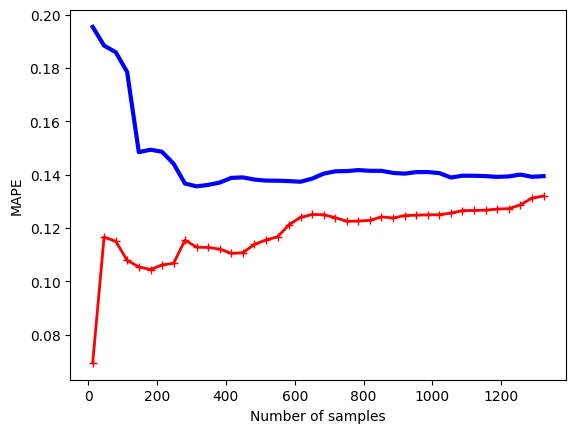

In [13]:
%%time
train_and_plot_learning_curve(ela_net_reg, X, y)

# Target transformer

In [14]:
%%time
ela_net_reg = make_pipeline(preprocessing, ElasticNet())
ela_net_reg = TransformedTargetRegressor(ela_net_reg, transformer=StandardScaler())
ela_net_reg_mapes = cross_val_score(ela_net_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(ela_net_reg_mapes).describe()

CPU times: user 2 s, sys: 7.41 s, total: 9.41 s
Wall time: 617 ms


count    10.000000
mean      0.189398
std       0.030577
min       0.148812
25%       0.165126
50%       0.190039
75%       0.213450
max       0.229389
dtype: float64

CPU times: user 563 ms, sys: 197 ms, total: 760 ms
Wall time: 885 ms


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Number of samples', ylabel='MAPE'>)

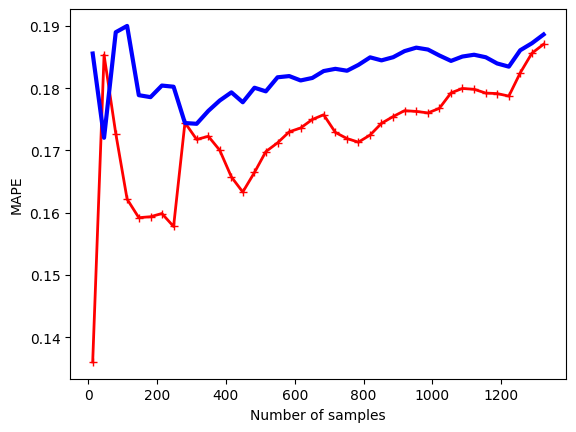

In [15]:
%%time
train_and_plot_learning_curve(ela_net_reg, X, y)

# Grid Search

In [16]:
%%time

ela_net_reg = make_pipeline(preprocessing, ElasticNet(max_iter=MAX_ITER))

parameters = {
 'elasticnet__alpha': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
 'elasticnet__l1_ratio': [.1, .2, .3, .4, .5, .6, .7, .8, .9],
 }

ela_net_grid = GridSearchCV(ela_net_reg, parameters, n_jobs=-1, cv=10, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
ela_net_grid.fit(X, y)

CPU times: user 1.77 s, sys: 482 ms, total: 2.26 s
Wall time: 3.43 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a171df910>)])),
                                       ('elasticnet',
                                        ElasticNet(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                               0.7, 0.8, 0.9, 1],
                         'elasticnet__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [17]:
ela_net_grid.best_params_

{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}

# Best Model

In [18]:
best_params = {key.split('__')[-1]: value for key, value in ela_net_grid.best_params_.items()}
best_params

{'alpha': 0.1, 'l1_ratio': 0.1}

In [19]:
%%time
ela_net_reg = make_pipeline(preprocessing, ElasticNet(max_iter=MAX_ITER, **best_params))
ela_net_reg_mapes = cross_val_score(ela_net_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(ela_net_reg_mapes).describe()

CPU times: user 1.58 s, sys: 5.7 s, total: 7.28 s
Wall time: 478 ms


count    10.000000
mean      0.105297
std       0.021163
min       0.078373
25%       0.092816
50%       0.101654
75%       0.114368
max       0.152110
dtype: float64

CPU times: user 536 ms, sys: 207 ms, total: 743 ms
Wall time: 916 ms


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Number of samples', ylabel='MAPE'>)

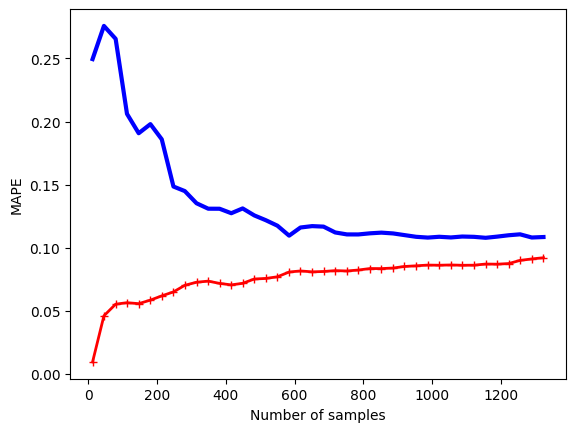

In [20]:
%%time
train_and_plot_learning_curve(ela_net_reg, X, y)